In [101]:
import pandas as pd
import numpy as np
pd.set_option("mode.copy_on_write", True)
import seaborn as sns
import matplotlib.pyplot as plt
import os

import matplotlib.dates as mdates

base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
data_path = os.path.join(base_dir, "data", "coffee_sales.csv")
print(f"Project dir: {base_dir}")

Project dir: /Users/diegorodriguezescalona/Documents/Duke/Classes/3-Fall_2025/Data_Vizualization/Coffee_Analysis


In [102]:
# Load Coffee Sales dataset
df = pd.read_csv(data_path)
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d", errors="coerce")
df.head()

,hour_of_day,cash_type,money,coffee_name,Time_of_Day,Weekday,Month_name,Weekdaysort,Monthsort,Date,Time
0,10,card,38.7,Latte,Morning,Fri,Mar,5,3,2024-03-01,10:15:50.520000
1,12,card,38.7,Hot Chocolate,Afternoon,Fri,Mar,5,3,2024-03-01,12:19:22.539000
2,12,card,38.7,Hot Chocolate,Afternoon,Fri,Mar,5,3,2024-03-01,12:20:18.089000
3,13,card,28.9,Americano,Afternoon,Fri,Mar,5,3,2024-03-01,13:46:33.006000
4,13,card,38.7,Latte,Afternoon,Fri,Mar,5,3,2024-03-01,13:48:14.626000


In [103]:
# --- 1) Aggregate your data
hourly_sales = (
    df.groupby(["Date", "hour_of_day", "coffee_name"], as_index=False)
      .agg(
          unit_count=("coffee_name", "count"),
          unit_price=("money", "mean"),
          total_sales=("money", "sum")
      )
)

# --- 2) Use only available hour range
min_hour = int(df["hour_of_day"].min())
max_hour = int(df["hour_of_day"].max())

all_dates  = sorted(df["Date"].unique())
all_hours  = list(range(min_hour, max_hour + 1))
all_drinks = sorted(df["coffee_name"].unique())

# --- 3) Build full Date × hour × coffee_name grid
full_index = pd.MultiIndex.from_product(
    [all_dates, all_hours, all_drinks],
    names=["Date", "hour_of_day", "coffee_name"]
)

hourly_full = (
    hourly_sales
    .set_index(["Date", "hour_of_day", "coffee_name"])
    .reindex(full_index)
    .reset_index()
)

# --- 4) Fill missing values
hourly_full["unit_count"]  = hourly_full["unit_count"].fillna(0).astype(int)
hourly_full["total_sales"] = hourly_full["total_sales"].fillna(0.0)

# Optional: fill price per drink with typical value (median per coffee)
menu_price = df.groupby("coffee_name")["money"].median()
hourly_full["unit_price"] = hourly_full["unit_price"].fillna(
    hourly_full["coffee_name"].map(menu_price)
)

# --- 5) Add Lactose category
milk = {"Latte", "Cappuccino", "Cortado", "Americano with Milk"}
hourly_full["Lactose"] = hourly_full["coffee_name"].apply(
    lambda x: "Milk-based" if x in milk else "Non milk-based"
)

hourly_full.head()


,Date,hour_of_day,coffee_name,unit_count,unit_price,total_sales,Lactose
0,2024-03-01,6,Americano,0,25.96,0.0,Non milk-based
1,2024-03-01,6,Americano with Milk,0,30.86,0.0,Milk-based
2,2024-03-01,6,Cappuccino,0,35.76,0.0,Milk-based
3,2024-03-01,6,Cocoa,0,35.76,0.0,Non milk-based
4,2024-03-01,6,Cortado,0,25.96,0.0,Milk-based


In [104]:
# 1) LONG form: one row per coffee_name per day
daily_sales = (
    df.groupby(["Date", "coffee_name"], as_index=False)["money"]
      .sum()
      .rename(columns={"money": "daily_sales"})
      .sort_values(["Date", "coffee_name"])
)
daily_sales.head()

,Date,coffee_name,daily_sales
0,2024-03-01,Americano,28.9
1,2024-03-01,Americano with Milk,135.2
2,2024-03-01,Cocoa,38.7
3,2024-03-01,Hot Chocolate,116.1
4,2024-03-01,Latte,77.4


In [105]:
context_cols = df[["Date", "Weekday", "Month_name", "Monthsort"]].drop_duplicates("Date")
daily_sales = daily_sales.merge(context_cols, on="Date", how="left")
daily_sales.head()

,Date,coffee_name,daily_sales,Weekday,Month_name,Monthsort
0,2024-03-01,Americano,28.9,Fri,Mar,3
1,2024-03-01,Americano with Milk,135.2,Fri,Mar,3
2,2024-03-01,Cocoa,38.7,Fri,Mar,3
3,2024-03-01,Hot Chocolate,116.1,Fri,Mar,3
4,2024-03-01,Latte,77.4,Fri,Mar,3


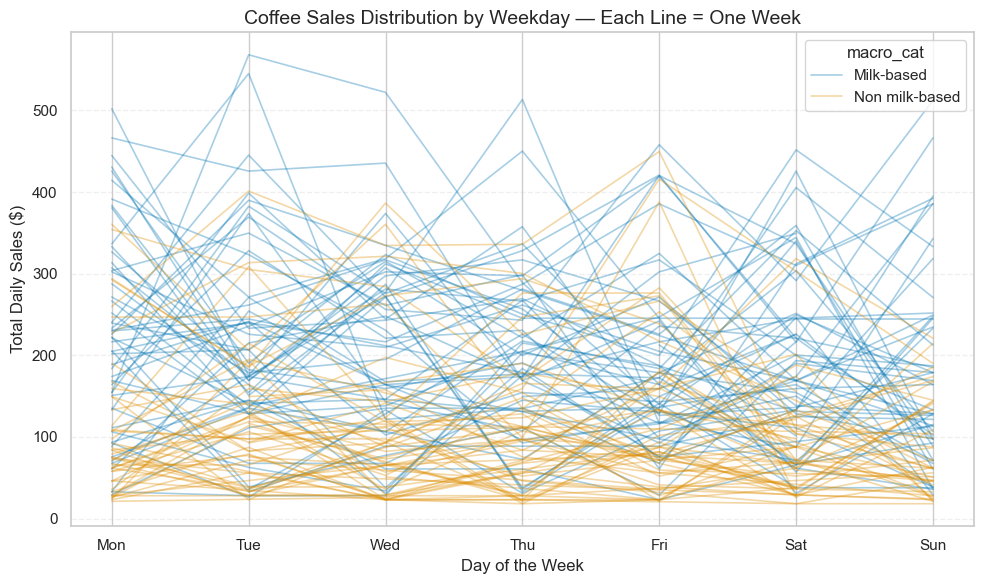

In [106]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Weekday order
weekday_order = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]

# 1) Make sure Date is datetime
daily_sales["Date"] = pd.to_datetime(daily_sales["Date"], errors="coerce")

# 2) Macro category
milk = {"Latte", "Cappuccino", "Cortado", "Americano with Milk"}
daily_sales["macro_cat"] = daily_sales["coffee_name"].apply(
    lambda x: "Milk-based" if x in milk else "Non milk-based"
)

# 3) Aggregate to Date × macro_cat (keep per-day variation)
daily_sales2 = (
    daily_sales.groupby(["Date", "macro_cat"], as_index=False)["daily_sales"]
               .sum()
)

# 4) Bring Weekday back (don’t group by it — just carry it over by Date)
weekday_lookup = (
    daily_sales[["Date", "Weekday"]]
    .drop_duplicates("Date")
)

daily_sales2 = daily_sales2.merge(weekday_lookup, on="Date", how="left")
daily_sales2["Weekday"] = pd.Categorical(daily_sales2["Weekday"],
                                         categories=weekday_order, ordered=True)

# 5) One line per week (Mon→Sun) for each category
daily_sales2["week_id"] = daily_sales2["Date"].dt.strftime("%Y-W%U")

# 6) Plot: each thin line = one week, colored by macro category
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,6))
sns.lineplot(
    data=daily_sales2.sort_values(["macro_cat", "week_id", "Weekday"]),
    x="Weekday", y="daily_sales",
    hue="macro_cat",
    units="week_id",      # one line per week
    estimator=None,       # no aggregation
    alpha=0.35, linewidth=1.2,
    palette="colorblind"
)

plt.title("Coffee Sales Distribution by Weekday — Each Line = One Week", fontsize=14)
plt.xlabel("Day of the Week")
plt.ylabel("Total Daily Sales ($)")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


There is not a clear seasonal pattern across days of the week.

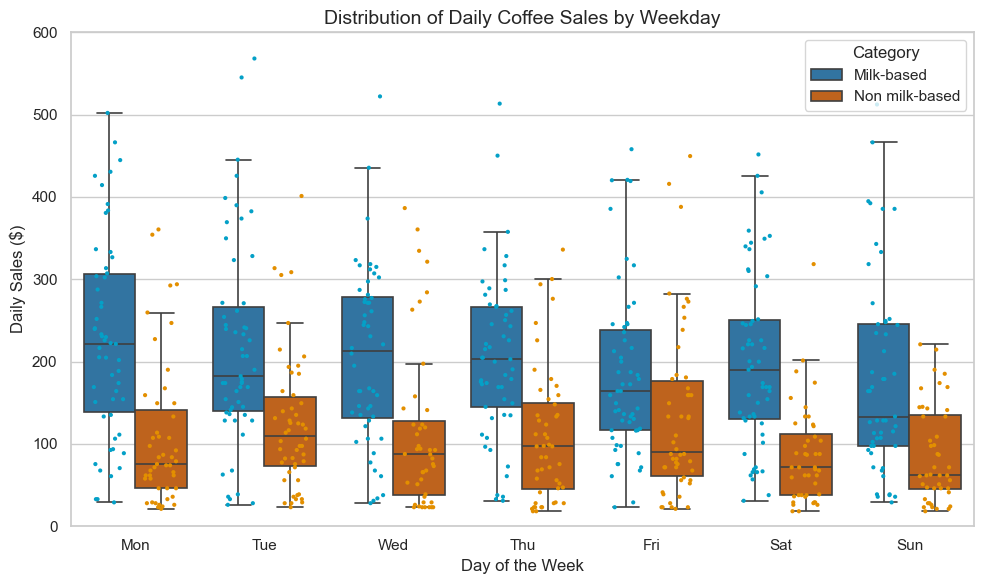

In [107]:

# Ensure proper weekday order
weekday_order = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]

# Convert Date and create macro category
daily_sales["Date"] = pd.to_datetime(daily_sales["Date"], errors="coerce")
milk = {"Latte", "Cappuccino", "Cortado", "Americano with Milk"}
daily_sales["macro_cat"] = daily_sales["coffee_name"].apply(
    lambda x: "Milk-based" if x in milk else "Non milk-based"
)

# Aggregate to Date × macro_cat
daily_sales2 = (
    daily_sales.groupby(["Date", "macro_cat"], as_index=False)["daily_sales"]
               .sum()
)

# Add weekday info
weekday_lookup = daily_sales[["Date", "Weekday"]].drop_duplicates("Date")
daily_sales2 = daily_sales2.merge(weekday_lookup, on="Date", how="left")
daily_sales2["Weekday"] = pd.Categorical(
    daily_sales2["Weekday"], categories=weekday_order, ordered=True
)

# --- Plot: Boxplot + jittered points (custom palette) ---
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,6))

# Define custom colors
box_colors = ["#1f77b4", "#d95f02"]   # dark blue, dark orange
dot_colors = ["#04A0C7", "#E38F00"]   # light blue, light orange

# Box plot for overall distribution per weekday
sns.boxplot(
    data=daily_sales2,
    x="Weekday", y="daily_sales",
    hue="macro_cat",
    palette=box_colors,
    dodge=True, fliersize=0,
    linewidth=1.2
)

# Add jittered individual data points
sns.stripplot(
    data=daily_sales2,
    x="Weekday", y="daily_sales",
    hue="macro_cat",
    dodge=True, jitter=0.25,
    size=3, alpha=1, linewidth=0,
    palette=dot_colors
)

# Clean legend (avoid duplicates)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title="Category")
plt.ylim(0,600)
plt.title("Distribution of Daily Coffee Sales by Weekday", fontsize=14)
plt.xlabel("Day of the Week")
plt.ylabel("Daily Sales ($)")
plt.tight_layout()
plt.show()



Milk based drinks consistently oversells non-milk base drinks.

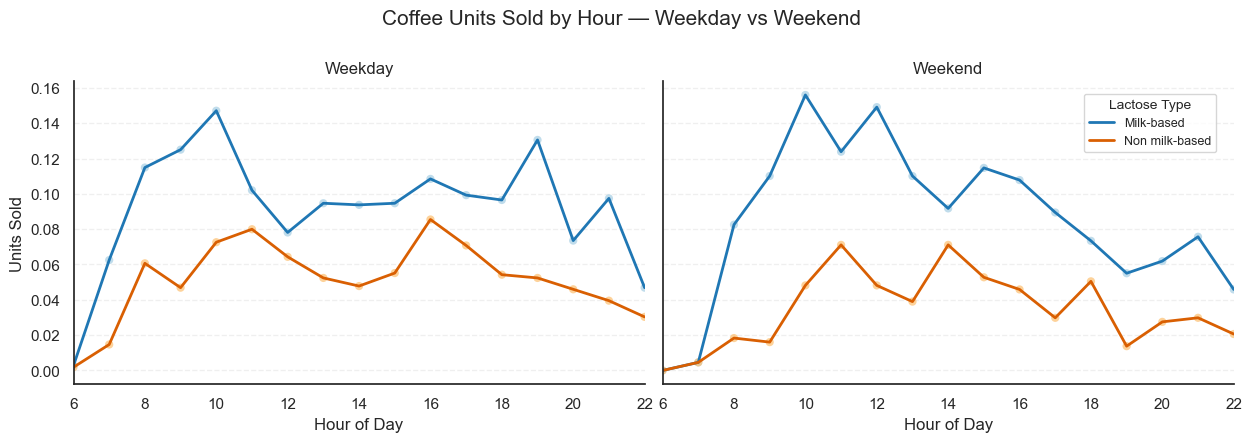

In [108]:
sns.set_theme(style="white")

# --- 1️⃣ Create weekend indicator ---
# Make sure Date is datetime
hourly_full["Date"] = pd.to_datetime(hourly_full["Date"], errors="coerce")

# Map weekday numbers (Mon=0 ... Sun=6)
hourly_full["is_weekend"] = hourly_full["Date"].dt.dayofweek >= 5
hourly_full["week_type"] = hourly_full["is_weekend"].map({True: "Weekend", False: "Weekday"})

# --- 2️⃣ Aggregate by hour × week_type × Lactose ---
hourly_pattern = (
    hourly_full.groupby(["hour_of_day", "week_type", "Lactose"], as_index=False)
                .agg(total_units=("unit_count", "mean"))
)

# --- 3️⃣ Plot ---
g = sns.FacetGrid(
    hourly_pattern,
    col="week_type",
    height=4.5, aspect=1.4,
    sharey=True
)

# Line plot
g.map_dataframe(
    sns.lineplot,
    x="hour_of_day", y="total_units",
    hue="Lactose",
    palette=["#1f77b4", "#d95f02"],
    linewidth=2
)

# Scatter points
g.map_dataframe(
    sns.scatterplot,
    x="hour_of_day", y="total_units",
    hue="Lactose",
    palette=["#a6cee3", "#fdbf6f"],
    s=35, alpha=0.7, linewidth=0
)

# --- 4️⃣ Style & labels ---
g.set_axis_labels("Hour of Day", "Units Sold")
g.set_titles("{col_name}")

# Remove global legend
if g._legend is not None:
    g._legend.remove()

# Place ONE legend inside the right subplot
right_ax = g.axes.flatten()[-1]  # the last facet (usually 'Weekend')
handles, labels = right_ax.get_legend_handles_labels()
right_ax.legend(
    handles[:2], labels[:2],
    title="Lactose Type",
    loc="upper right",
    bbox_to_anchor=(0.98, 0.98),
    frameon=True,
    fontsize=9,
    title_fontsize=10
)

# Adjust x ticks and layout
for ax in g.axes.flatten():
    ax.set_xticks(range(6, 23, 2))
    ax.set_xlim(6, 22)
    ax.grid(axis="y", linestyle="--", alpha=0.3)

plt.subplots_adjust(top=0.82)
g.fig.suptitle("Coffee Units Sold by Hour — Weekday vs Weekend", fontsize=15)
plt.show()

This consistently happens within hours of the day

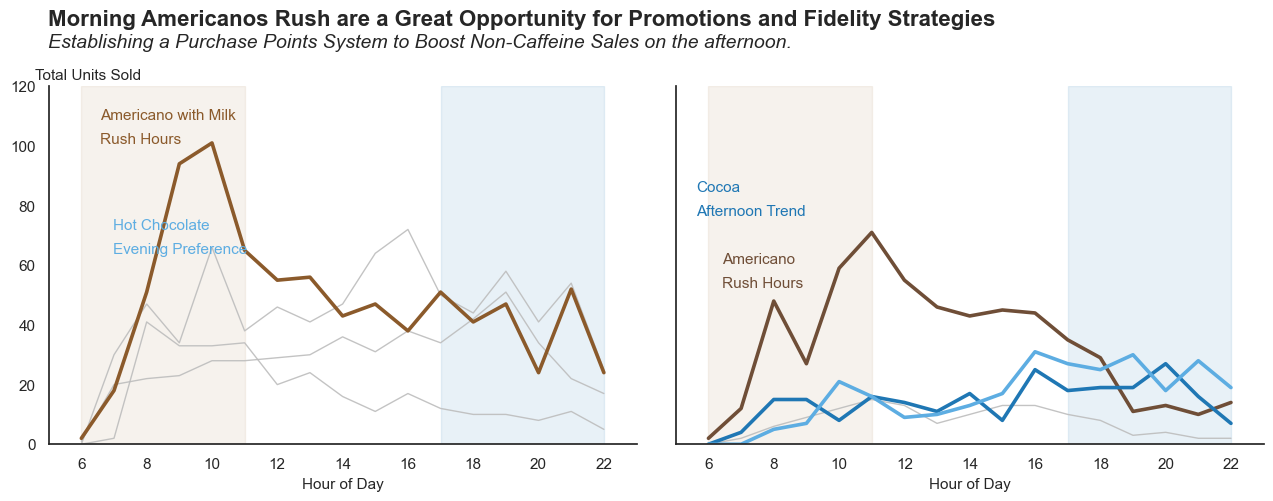

In [109]:
sns.set_theme(style="white")

# 1) Aggregate (as you had)
hourly_pattern = (
    hourly_full.groupby(["hour_of_day", "Lactose", "coffee_name"], as_index=False)
               .agg(total_units=("unit_count", "sum"))
)

# 2) Colors
highlight_names  = ["Americano", "Americano with Milk", "Cocoa", "Hot Chocolate"]

highlight_colors = {
    "Americano": "#6F4E37",            # dark coffee brown
    "Americano with Milk": "#8B5A2B",  # lighter brown
    "Cocoa": "#1f77b4",                # dark blue
    "Hot Chocolate": "#5DADE2"         # light blue
}

all_drinks = hourly_pattern["coffee_name"].unique()
gray_palette = {name: "#BDBDBD" for name in all_drinks}  # 

# 3) Build FacetGrid by Lactose
g = sns.FacetGrid(
    hourly_pattern,
    col="Lactose",
    height=4.8, aspect=1.35,
    sharey=True
)

# 4) Plot: first ALL lines in gray (low prominence)
for lactose, ax in zip(g.col_names, g.axes.flatten()):
    data_facet = hourly_pattern[hourly_pattern["Lactose"] == lactose]

    # Base gray lines for every coffee
    sns.lineplot(
        data=data_facet,
        x="hour_of_day", y="total_units",
        hue="coffee_name",
        palette=gray_palette,
        linewidth=1.0, alpha=0.9,
        legend=False, ax=ax
    )

    # Then overlay the highlighted coffees (thicker + brown)
    data_high = data_facet[data_facet["coffee_name"].isin(highlight_names)]
    if not data_high.empty:
        sns.lineplot(
            data=data_high,
            x="hour_of_day", y="total_units",
            hue="coffee_name",
            palette=highlight_colors,
            linewidth=2.6, alpha=1.0,
            legend=False, ax=ax
        )

    # 5) Shade morning rush window (7–12)
    ax.axvspan(6, 11, color="#C4A484", alpha=0.14, zorder=0)  # light brown
    ax.axvspan(17, 22, color="#1f77b4", alpha=0.10, zorder=0)  # light brown

    # Ax formatting
    min_hour = int(data_facet["hour_of_day"].min()-1)
    max_hour = int(data_facet["hour_of_day"].max()+1)
    ax.set_xlim(min_hour, max_hour)
    ax.set_ylim(0, 120)
    # If you want fixed café hours instead, use: ax.set_xlim(6, 22)
    xticks = np.arange(min_hour + (min_hour % 2 == 1), max_hour + 1, 2)  # every 2 hours

    ax.set_xlabel("Hour of Day", fontsize=11)
    ax.set_ylabel("Total Units Sold ", rotation=0, fontsize=11)
    ax.yaxis.set_label_coords(0.07, 1.01)  # horizontal label above y-axis

# 7) Labels and titles (no legends)

g.set_titles("")

plt.subplots_adjust(top=0.84)
g.fig.suptitle("Morning Americanos Rush are a Great Opportunity for Promotions and Fidelity Strategies", fontsize=16, fontweight="bold", 
               x=0.04, y=1.00, ha="left")

g.fig.text(0.04, 0.92, "Establishing a Purchase Points System to Boost Non-Caffeine Sales on the afternoon.", 
           fontsize=14,fontstyle="italic")

# --- Americano with Milk
g.fig.text(0.08, 0.78, "Americano with Milk", fontsize=11, color="#8B5A2B", va="center")
g.fig.text(0.08, 0.73, "Rush Hours", fontsize=11, color="#8B5A2B", va="center")

# --- Americano
g.fig.text(0.56, 0.48, "Americano", fontsize=11, color="#6F4E37", va="center")
g.fig.text(0.56, 0.43, "Rush Hours", fontsize=11, color="#6F4E37", va="center")

# --- Cocoa
g.fig.text(0.54, 0.63, "Cocoa", fontsize=11, color="#1f77b4", va="center")
g.fig.text(0.54, 0.58, "Afternoon Trend", fontsize=11, color="#1f77b4", va="center")

# --- Hot Chocolate
g.fig.text(0.09, 0.55, "Hot Chocolate", fontsize=11, color="#5DADE2", va="center")
g.fig.text(0.09, 0.50, "Evening Preference", fontsize=11, color="#5DADE2", va="center")

plt.show()

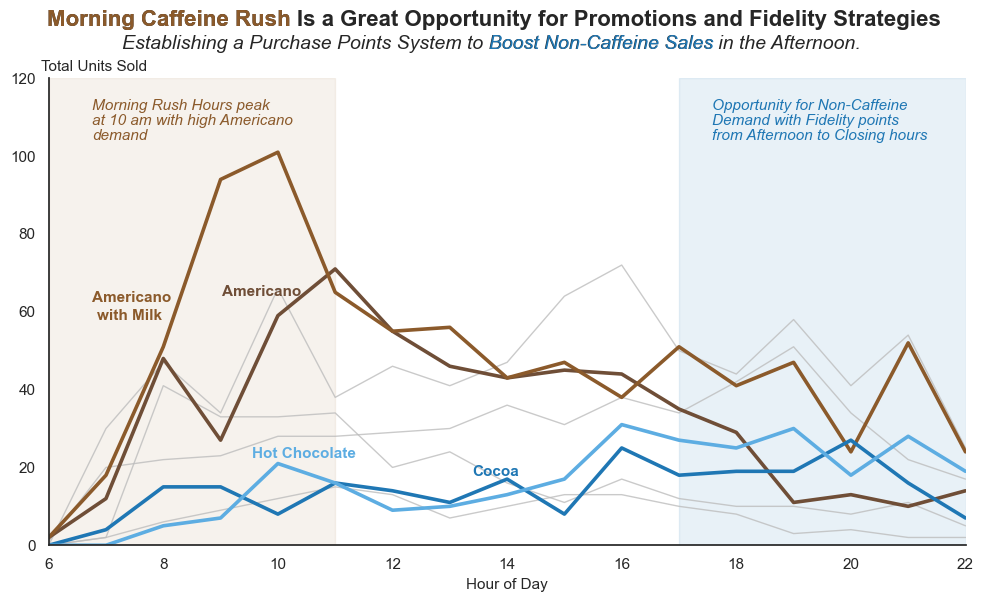

In [110]:
sns.set_theme(style="white")

# 1️⃣ Aggregate across all lactose types
hourly_pattern = (
    hourly_full.groupby(["hour_of_day", "coffee_name"], as_index=False)
               .agg(total_units=("unit_count", "sum"))
)

# 2️⃣ Colors
highlight_names  = ["Americano", "Americano with Milk", "Cocoa", "Hot Chocolate"]
highlight_colors = {
    "Americano": "#6F4E37",            # dark coffee brown
    "Americano with Milk": "#8B5A2B",  # lighter brown
    "Cocoa": "#1f77b4",                # dark blue
    "Hot Chocolate": "#5DADE2"         # light blue
}

all_drinks = hourly_pattern["coffee_name"].unique()
gray_palette = {name: "#BDBDBD" for name in all_drinks}

# 3️⃣ Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Base gray lines (all other coffees)
sns.lineplot(
    data=hourly_pattern,
    x="hour_of_day", y="total_units",
    hue="coffee_name",
    palette=gray_palette,
    linewidth=1.0, alpha=0.8,
    legend=False, ax=ax
)

# Highlighted lines (browns + blues)
data_high = hourly_pattern[hourly_pattern["coffee_name"].isin(highlight_names)]
sns.lineplot(
    data=data_high,
    x="hour_of_day", y="total_units",
    hue="coffee_name",
    palette=highlight_colors,
    linewidth=2.6, alpha=1.0,
    legend=False, ax=ax
)

# 4️⃣ Shade morning rush window
ax.axvspan(6, 11, color="#C4A484", alpha=0.14, zorder=0)
ax.axvspan(17, 22, color="#1f77b4", alpha=0.10, zorder=0)

# 5️⃣ Axis styling
min_hour = int(hourly_pattern["hour_of_day"].min())
max_hour = int(hourly_pattern["hour_of_day"].max())
ax.set_xlim(min_hour, max_hour)
ax.set_ylim(0, 120)
ax.set_xticks(np.arange(min_hour, max_hour + 1, 2))


# 6️⃣ Axis labels
ax.set_xlabel("Hour of Day", fontsize=11)
ax.set_ylabel("Total Units Sold", rotation=0, fontsize=11)
ax.yaxis.set_label_coords(0.05, 1.01)  # horizontal y-axis label above axis

# 🔹 Remove upper and right spines for a cleaner look
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# 7️⃣ Titles and descriptive text
fig.suptitle(
    "Morning Caffeine Rush Is a Great Opportunity for Promotions and Fidelity Strategies",
    fontsize=16, fontweight="bold", x=0.055, y=1.00, ha="left"
)
fig.text(
    0.13, 0.935,
    "Establishing a Purchase Points System to Boost Non-Caffeine Sales in the Afternoon.",
    fontsize=14, fontstyle="italic"
)

# 8️⃣ Inline annotations
# Americano with Milk
fig.text(0.10, 0.52, "Americano", fontsize=11, color="#8B5A2B",
         va="center", fontweight="bold")
fig.text(0.105, 0.49, "with Milk", fontsize=11, color="#8B5A2B", 
         va="center", fontweight="bold")

# Americano
fig.text(0.23, 0.53, "Americano", fontsize=11, color="#6F4E37", 
         va="center", fontweight="bold")


# Cocoa
fig.text(0.48, 0.23, "Cocoa", fontsize=11, color="#1f77b4",
        va="center", fontweight="bold")


# Hot Chocolate
fig.text(0.26, 0.26, "Hot Chocolate", fontsize=11, color="#5DADE2", 
        va="center", fontweight="bold")

#Morning Rush Hours
fig.text(0.1, 0.84, "Morning Rush Hours peak", fontsize=11, color="#8B5A2B", 
        va="center", fontstyle="italic")
fig.text(0.1, 0.815, "at 10 am with high Americano", fontsize=11, color="#8B5A2B", 
        va="center", fontstyle="italic")
fig.text(0.1, 0.79, "demand", fontsize=11, color="#8B5A2B", 
        va="center", fontstyle="italic")

#Morning Rush Hours
fig.text(0.72, 0.84, "Opportunity for Non-Caffeine", fontsize=11, color="#1f77b4", 
        va="center", fontstyle="italic")
fig.text(0.72, 0.815, "Demand with Fidelity points", fontsize=11, color="#1f77b4", 
        va="center", fontstyle="italic")
fig.text(0.72, 0.79, "from Afternoon to Closing hours", fontsize=11, color="#1f77b4", 
        va="center", fontstyle="italic")

fig.text(
    0.4966, 0.935,
    "Boost Non-Caffeine Sales",
    fontsize=14, fontstyle="italic", color="#1f77b4")

fig.text(
    0.055, 0.973,
    "Morning Caffeine Rush",
    fontsize=16, fontweight="bold", color="#8B5A2B")


plt.tight_layout()
plt.show()


/var/folders/lc/0t55gl5x2jlfvzbcdbwvwb3h0000gn/T/ipykernel_26509/3286175974.py:82: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(sub["total_units"]) if not sub.empty else None


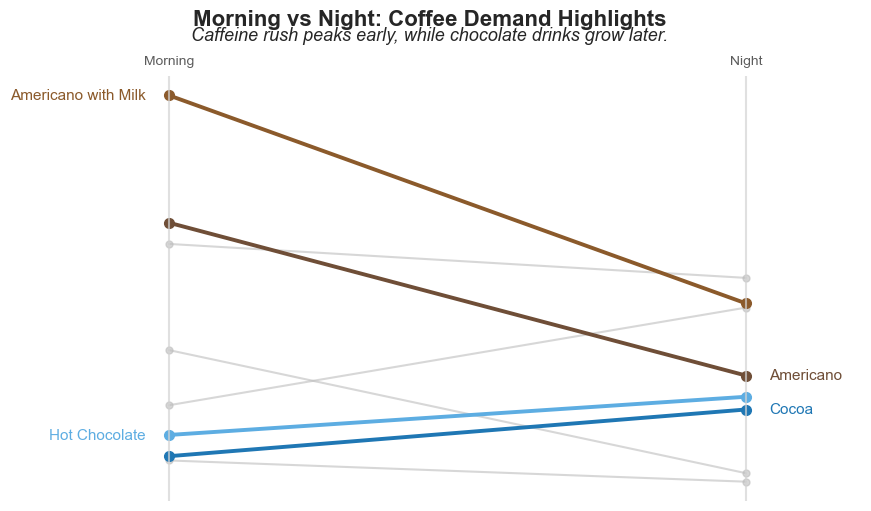

In [111]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------- 1) Aggregate hourly totals ----------
hourly_totals = (
    hourly_full.groupby(["hour_of_day", "coffee_name"], as_index=False)["unit_count"]
               .sum()
               .rename(columns={"unit_count": "total_units"})
)

# ---------- 2) Define stages and compute per-drink max within each stage ----------
morning_hours = list(range(6, 12))   # 6–11 inclusive
night_hours   = list(range(17, 23))  # 17–22 inclusive

def stage_max(df, hours, stage):
    tmp = (df[df["hour_of_day"].isin(hours)]
           .groupby("coffee_name", as_index=False)["total_units"].max())
    tmp["stage"] = stage
    return tmp

morning = stage_max(hourly_totals, morning_hours, "Morning")
night   = stage_max(hourly_totals, night_hours, "Night")
stage_df = pd.concat([morning, night], ignore_index=True)

# Ensure both stages exist for each drink (so lines connect)
all_series = pd.DataFrame({
    "coffee_name": stage_df["coffee_name"].unique().repeat(2),
    "stage": ["Morning","Night"] * stage_df["coffee_name"].nunique()
})
plot_df = (all_series.merge(stage_df, on=["coffee_name","stage"], how="left")
                     .fillna({"total_units": 0}))

# Numeric x for categorical stages (so axvline aligns perfectly)
stage_map = {"Morning": 0, "Night": 1}
plot_df["x"] = plot_df["stage"].map(stage_map)

# ---------- 3) Colors ----------
highlight_names  = ["Americano", "Americano with Milk", "Cocoa", "Hot Chocolate"]
highlight_colors = {
    "Americano": "#6F4E37",            # dark coffee brown
    "Americano with Milk": "#8B5A2B",  # lighter brown
    "Cocoa": "#1f77b4",                # dark blue
    "Hot Chocolate": "#5DADE2"         # light blue
}
# Default gray for non-highlight drinks
default_gray = "#BDBDBD"

# ---------- 4) Plot (minimalist) ----------
fig, ax = plt.subplots(figsize=(9, 5.2))

# Plot all non-highlight drinks first (thin gray, subtle)
for name in sorted(set(plot_df["coffee_name"]) - set(highlight_names)):
    sdata = plot_df[plot_df["coffee_name"] == name].sort_values("x")
    ax.plot(sdata["x"], sdata["total_units"],
            marker="o", markersize=5, linewidth=1.5,
            color=default_gray, alpha=0.6)

# Plot highlights on top (thicker, colored)
for name in highlight_names:
    sdata = plot_df[plot_df["coffee_name"] == name].sort_values("x")
    if sdata.empty:
        continue
    ax.plot(sdata["x"], sdata["total_units"],
            marker="o", markersize=7, linewidth=2.8,
            color=highlight_colors[name], alpha=1.0)

# ---------- 5) Minimalist styling ----------
# Vertical reference lines at Morning (0) and Night (1)
ax.axvline(x=0, color="#D3D3D3", linestyle="-", linewidth=1.5, alpha=0.7)
ax.axvline(x=1, color="#D3D3D3", linestyle="-", linewidth=1.5, alpha=0.7)

# Remove axes, ticks, grid, spines
ax.set_xlim(-0.2, 1.2)
ax.set_xticks([]); ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)

# ---------- 6) Inline labels for the highlighted series (no legend) ----------
# Place labels just outside the left/right edges at the series' Morning/Night values
def y_at(series_name, stage_name):
    sub = plot_df[(plot_df["coffee_name"] == series_name) & (plot_df["stage"] == stage_name)]
    return float(sub["total_units"]) if not sub.empty else None

# Left (Morning) labels
y = y_at("Americano with Milk", "Morning")
if y is not None:
    ax.text(-0.04, y, "Americano with Milk", color=highlight_colors["Americano with Milk"],
            fontsize=11, ha="right", va="center")
y = y_at("Hot Chocolate", "Morning")
if y is not None:
    ax.text(-0.04, y, "Hot Chocolate", color=highlight_colors["Hot Chocolate"],
            fontsize=11, ha="right", va="center")

# Right (Night) labels
y = y_at("Americano", "Night")
if y is not None:
    ax.text(1.04, y, "Americano", color=highlight_colors["Americano"],
            fontsize=11, ha="left", va="center")
y = y_at("Cocoa", "Night")
if y is not None:
    ax.text(1.04, y, "Cocoa", color=highlight_colors["Cocoa"],
            fontsize=11, ha="left", va="center")

# Optional: label the two x positions themselves (very light)
ax.text(0, ax.get_ylim()[1]*1.02, "Morning", ha="center", va="bottom", fontsize=10, alpha=0.75)
ax.text(1, ax.get_ylim()[1]*1.02, "Night",   ha="center", va="bottom", fontsize=10, alpha=0.75)

# ---------- 7) Title & subtitle ----------
fig.suptitle("Morning vs Night: Coffee Demand Highlights", fontsize=16, fontweight="bold")
fig.text(0.5, 0.92, "Caffeine rush peaks early, while chocolate drinks grow later.",
         fontsize=13, fontstyle="italic", ha="center")

plt.tight_layout()
plt.show()
